**MOUNT THE GOOGLE DRIVE **

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**UNZIP THE DATASET**

In [ ]:
!unzip "/content/drive/MyDrive/LiTS_dataset.zip" -d /content/

Archive:  /content/drive/MyDrive/LiTS_dataset.zip
   creating: /content/LiTS_dataset/
   creating: /content/LiTS_dataset/.git/
  inflating: /content/LiTS_dataset/.git/config  
  inflating: /content/LiTS_dataset/.git/description  
  inflating: /content/LiTS_dataset/.git/HEAD  
   creating: /content/LiTS_dataset/.git/hooks/
  inflating: /content/LiTS_dataset/.git/hooks/applypatch-msg.sample  
  inflating: /content/LiTS_dataset/.git/hooks/commit-msg.sample  
  inflating: /content/LiTS_dataset/.git/hooks/fsmonitor-watchman.sample  
  inflating: /content/LiTS_dataset/.git/hooks/post-update.sample  
  inflating: /content/LiTS_dataset/.git/hooks/pre-applypatch.sample  
  inflating: /content/LiTS_dataset/.git/hooks/pre-commit.sample  
  inflating: /content/LiTS_dataset/.git/hooks/pre-merge-commit.sample  
  inflating: /content/LiTS_dataset/.git/hooks/pre-push.sample  
  inflating: /content/LiTS_dataset/.git/hooks/pre-rebase.sample  
  inflating: /content/LiTS_dataset/.git/hooks/pre-receive.sam

In [ ]:
import os
dataset_path = "/content/LiTS_dataset/"
print("Files:", os.listdir(dataset_path))

Files: ['.git', 'volume_pt3', 'volume_pt4', 'segmentations', 'volume_pt1', 'volume_pt5', 'volume_pt2']


**Load .nii Files**

Image shape: (512, 512, 75)
Mask shape: (512, 512, 75)


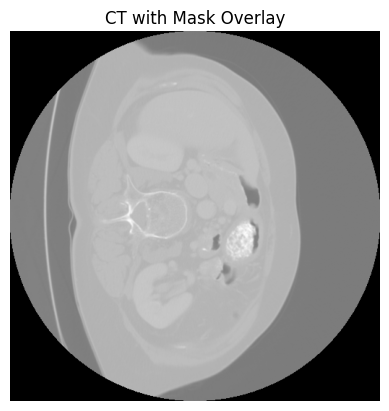

In [ ]:
def load_nifti(path):
    return nib.load(path).get_fdata()
image_path = '/content/LiTS_dataset/volume_pt1/volume-0.nii'
mask_path  = '/content/LiTS_dataset/segmentations/segmentation-0.nii'

image = load_nifti(image_path)
mask = load_nifti(mask_path)
print("Image shape:", image.shape)
print("Mask shape:", mask.shape)
plt.imshow(image[:, :, 50], cmap='gray')
plt.title("CT with Mask Overlay")
plt.axis('off')
plt.show()


In [ ]:
from skimage.transform import resize

def preprocess_volume(volume, mask, img_size=(128, 128)):
    X = []
    Y = []
    for i in range(volume.shape[2]):
        img_slice = volume[:, :, i]
        mask_slice = mask[:, :, i]
        if np.max(mask_slice) == 0:
            continue

        img_resized = resize(img_slice, img_size, preserve_range=True)
        mask_resized = resize(mask_slice, img_size, preserve_range=True)

        X.append(img_resized)
        Y.append(mask_resized)

    X = np.array(X)[..., np.newaxis] / np.max(X)
    Y = np.array(Y)[..., np.newaxis]
    Y = (Y > 0.5).astype(np.uint8)
    return X, Y

X, Y = preprocess_volume(image, mask)
print(X.shape, Y.shape)


(29, 128, 128, 1) (29, 128, 128, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def unet_model(input_size=(128, 128, 1)):
    inputs = tf.keras.Input(input_size)

    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)

    u1 = layers.UpSampling2D()(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(c4)

    u2 = layers.UpSampling2D()(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c5)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = unet_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 96)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │     27,680 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 48)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │      6,928 │ concatenate_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d_8[0][0]  

 Total params: 117,985 (460.88 KB)

 Trainable params: 117,985 (460.88 KB)

 Non-trainable params: 0 (0.00 B)

**FOR MULTIPLE VOLUMES**

In [ ]:
!mkdir /content/LiTS_dataset/images

# Move all volume*.nii into one 'images' folder
!find /content/LiTS_dataset -type f -name "volume-*.nii" -exec mv {} /content/LiTS_dataset/images/ \;


In [ ]:
def load_volume_slices(volume_path, mask_path, img_size=(128, 128)):
    volume = nib.load(volume_path).get_fdata()
    mask = nib.load(mask_path).get_fdata()

    X_slices = []
    Y_slices = []

    # Only go up to the smallest number of slices
    num_slices = min(volume.shape[2], mask.shape[2])

    for i in range(num_slices):
        img = volume[:, :, i]
        lbl = mask[:, :, i]

        img = np.interp(img, (img.min(), img.max()), (0, 1))
        img = np.resize(img, img_size)
        lbl = np.resize(lbl, img_size)

        X_slices.append(img)
        Y_slices.append((lbl > 0).astype(np.float32))

    return np.array(X_slices), np.array(Y_slices)


In [ ]:
# STEP 5: Load all volumes

def load_all_data(image_folder, mask_folder, img_size=(128, 128)):
    image_files = sorted(os.listdir(image_folder))
    mask_files = sorted(os.listdir(mask_folder))

    all_X, all_Y = [], []

    for i in range(len(image_files)):
        vol = os.path.join(image_folder, image_files[i])
        seg = os.path.join(mask_folder, mask_files[i])
        X, Y = load_volume_slices(vol, seg, img_size)
        all_X.append(X)
        all_Y.append(Y)

    return np.expand_dims(np.concatenate(all_X), -1), np.expand_dims(np.concatenate(all_Y), -1)

X, Y = load_all_data('/content/LiTS_dataset/images', '/content/LiTS_dataset/segmentations')


In [ ]:
# STEP 6: Train-Test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)


In [ ]:
# 📦 Required Imports
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 🧠 U-Net Model Definition
def unet(input_size=(128, 128, 1)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D(pool_size=(2, 2))(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D(pool_size=(2, 2))(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    # Output
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c9)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# 🧪 Create and Check Model
model = unet()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 128, 128,  │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_11[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_13[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_15[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 16, 16,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_4[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_17[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 8, 8, 512) │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_5[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 8, 8,      │  9,438,208 │ conv2d_19[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_20[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X, Y, epochs=20, batch_size=4, validation_split=0.1)


**INSIDE DATASET FOLDERS**

In [ ]:
import os

# List contents in the main folder
print("Main folder contents:", os.listdir('/content/LiTS_dataset'))

# Try to look inside each subfolder
for item in os.listdir('/content/LiTS_dataset'):
    path = os.path.join('/content/LiTS_dataset', item)
    if os.path.isdir(path):
        print(f"\n📂 Contents of {item}:")
        print(os.listdir(path))


Main folder contents: ['.git', 'volume_pt3', 'volume_pt4', 'segmentations', 'volume_pt1', 'volume_pt5', 'volume_pt2']

📂 Contents of .git:
['HEAD', 'packed-refs', 'info', 'index', 'config', 'objects', 'refs', 'hooks', 'logs', 'description']

📂 Contents of volume_pt3:
['volume-24.nii', 'volume-26.nii', 'volume-30.nii', 'volume-23.nii', 'volume-25.nii', 'volume-28.nii', 'volume-27.nii', 'volume-22.nii', 'volume-21.nii', 'volume-29.nii']

📂 Contents of volume_pt4:
['volume-40.nii', 'volume-32.nii', 'volume-37.nii', 'volume-39.nii', 'volume-35.nii', 'volume-38.nii', 'volume-34.nii', 'volume-33.nii', 'volume-36.nii', 'volume-31.nii']

📂 Contents of segmentations:
['segmentation-23.nii', 'segmentation-36.nii', 'segmentation-86.nii', 'segmentation-88.nii', 'segmentation-35.nii', 'segmentation-0.nii', 'segmentation-120.nii', 'segmentation-28.nii', 'segmentation-30.nii', 'segmentation-90.nii', 'segmentation-21.nii', 'segmentation-114.nii', 'segmentation-117.nii', 'segmentation-50.nii', 'segment

In [ ]:
import numpy as np

print("Unique values in Y_train:", np.unique(Y_train))


Unique values in Y_train: [0. 1.]


In [ ]:
pred = model.predict(np.expand_dims(X_test[idx], axis=0))[0, :, :, 0]
print("Prediction min:", np.min(pred), "max:", np.max(pred), "unique values:", np.unique(pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Prediction min: 0.0 max: 0.99999577 unique values: [0.0000000e+00 1.1957433e-38 1.2703492e-38 ... 9.9999481e-01 9.9999505e-01
 9.9999577e-01]


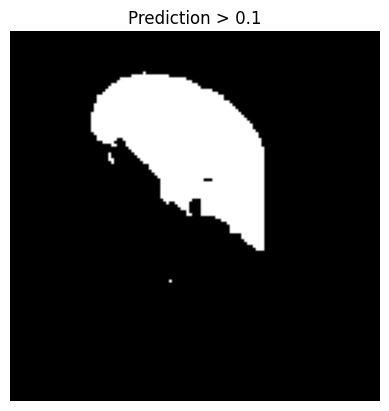

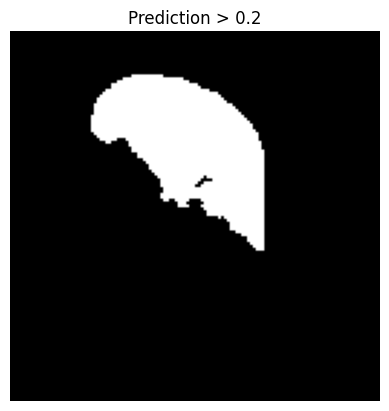

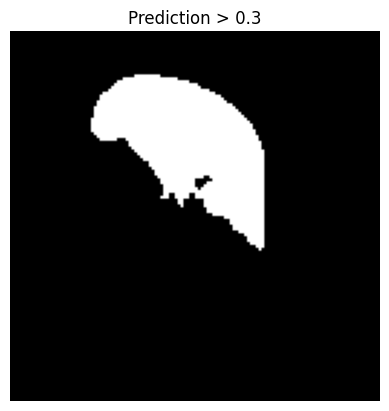

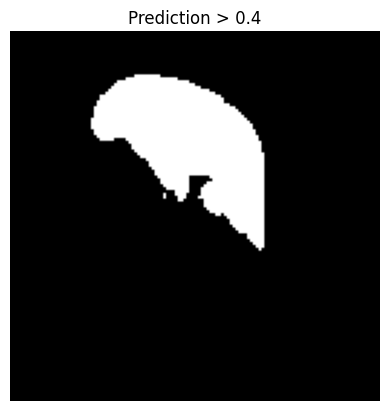

In [ ]:
for thresh in [0.1, 0.2, 0.3, 0.4]:
    plt.imshow(pred > thresh, cmap='gray')
    plt.title(f"Prediction > {thresh}")
    plt.axis('off')
    plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [ ]:
def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice


In [ ]:
model.compile(optimizer='adam',
              loss=dice_loss,       # or bce_dice_loss
              metrics=['accuracy'])


In [ ]:
history = model.fit(X_train, Y_train,
                    validation_data=(X_test, Y_test),
                    epochs=10,
                    batch_size=4)


Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 22s 418ms/step - accuracy: 0.9843 - loss: 0.7565 - val_accuracy: 0.9841 - val_loss: 0.5526
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 426ms/step - accuracy: 0.9868 - loss: 0.5408 - val_accuracy: 0.9720 - val_loss: 0.4872
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 19s 402ms/step - accuracy: 0.9839 - loss: 0.4775 - val_accuracy: 0.9878 - val_loss: 0.3807
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 397ms/step - accuracy: 0.9879 - loss: 0.3492 - val_accuracy: 0.9885 - val_loss: 0.3162
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 396ms/step - accuracy: 0.9888 - loss: 0.4132 - val_accuracy: 0.9899 - val_loss: 0.2967
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 394ms/step - accuracy: 0.9915 - loss: 0.4132 - val_accuracy: 0.9900 - val_loss: 0.2932
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 380ms/step - accuracy: 0.9922 - loss: 0.4629 - val_accuracy: 0.9870 - val_loss: 0.3080
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 394ms/step - accuracy: 0.9899 - loss: 0.2911 - val_accu

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
Prediction min: 0.0 max: 0.9998947381973267


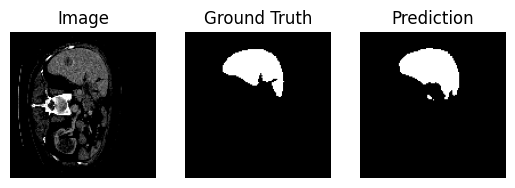

In [ ]:
pred = model.predict(X_test[idx:idx+1])[0]
print(f"Prediction min: {pred.min()} max: {pred.max()}")

# Visualize with lower threshold if needed
plt.subplot(1, 3, 1)
plt.imshow(X_test[idx, :, :, 0], cmap='gray')
plt.title("Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(Y_test[idx, :, :, 0], cmap='gray')
plt.title("Ground Truth")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(pred > 0.3, cmap='gray')  # You can adjust this
plt.title("Prediction")
plt.axis('off')

plt.show()


In [ ]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)


In [ ]:
model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy'])


In [ ]:
model.fit(X_train, Y_train, epochs=30, batch_size=2, validation_split=0.2)


Epoch 1/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 17s 219ms/step - accuracy: 0.9668 - loss: 0.4574 - val_accuracy: 0.9801 - val_loss: 0.4826
Epoch 2/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 14s 212ms/step - accuracy: 0.9872 - loss: 0.3152 - val_accuracy: 0.9884 - val_loss: 0.3303
Epoch 3/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 14s 210ms/step - accuracy: 0.9857 - loss: 0.4573 - val_accuracy: 0.9757 - val_loss: 0.6464
Epoch 4/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 20s 206ms/step - accuracy: 0.9834 - loss: 0.5797 - val_accuracy: 0.9757 - val_loss: 0.6464
Epoch 5/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 21s 211ms/step - accuracy: 0.9798 - loss: 0.6311 - val_accuracy: 0.9757 - val_loss: 0.6464
Epoch 6/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 20s 208ms/step - accuracy: 0.9779 - loss: 0.6555 - val_accuracy: 0.9757 - val_loss: 0.6464
Epoch 7/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 21s 211ms/step - accuracy: 0.9776 - loss: 0.6009 - val_accuracy: 0.9757 - val_loss: 0.6464
Epoch 8/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 20s 203ms/step - accuracy: 0.9731 - loss: 0.5877 - val_accu

In [ ]:
preds = model.predict(X_test)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


**Liver Tumor Segmentation**

In [ ]:
# Filter only those slices where ground truth mask has positive values
non_empty_indices = [i for i in range(len(Y_test)) if np.any(Y_test[i] > 0)]
print("Filtered non-empty test samples:", len(non_empty_indices))

X_test_nonempty = X_test[non_empty_indices]
Y_test_nonempty = Y_test[non_empty_indices]


Filtered non-empty test samples: 969


✅ Loaded: (4842, 128, 128, 1) (4842, 128, 128, 1)
Epoch 1/10
969/969 ━━━━━━━━━━━━━━━━━━━━ 580s 592ms/step - accuracy: 0.9376 - loss: 0.1825 - val_accuracy: 0.9676 - val_loss: 0.0772
Epoch 2/10
969/969 ━━━━━━━━━━━━━━━━━━━━ 585s 604ms/step - accuracy: 0.9725 - loss: 0.0670 - val_accuracy: 0.9845 - val_loss: 0.0388
Epoch 3/10
969/969 ━━━━━━━━━━━━━━━━━━━━ 624s 605ms/step - accuracy: 0.9855 - loss: 0.0365 - val_accuracy: 0.9901 - val_loss: 0.0256
Epoch 4/10
969/969 ━━━━━━━━━━━━━━━━━━━━ 627s 610ms/step - accuracy: 0.9896 - loss: 0.0266 - val_accuracy: 0.9922 - val_loss: 0.0198
Epoch 5/10
969/969 ━━━━━━━━━━━━━━━━━━━━ 616s 604ms/step - accuracy: 0.9919 - loss: 0.0204 - val_accuracy: 0.9932 - val_loss: 0.0172
Epoch 6/10
969/969 ━━━━━━━━━━━━━━━━━━━━ 618s 600ms/step - accuracy: 0.9930 - loss: 0.0179 - val_accuracy: 0.9931 - val_loss: 0.0173
Epoch 7/10
969/969 ━━━━━━━━━━━━━━━━━━━━ 582s 600ms/step - accuracy: 0.9942 - loss: 0.0147 - val_accuracy: 0.9937 - val_loss: 0.0158
Epoch 8/10
969/969 ━━━━━━━

31/31 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step
Prediction min: 0.0 max: 1.0


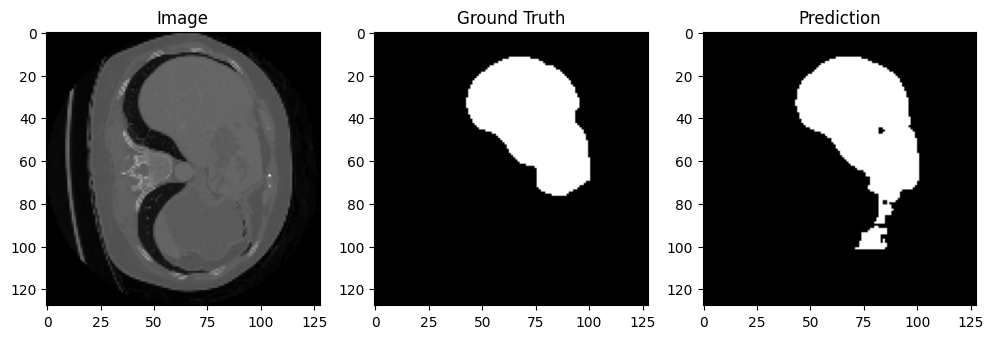

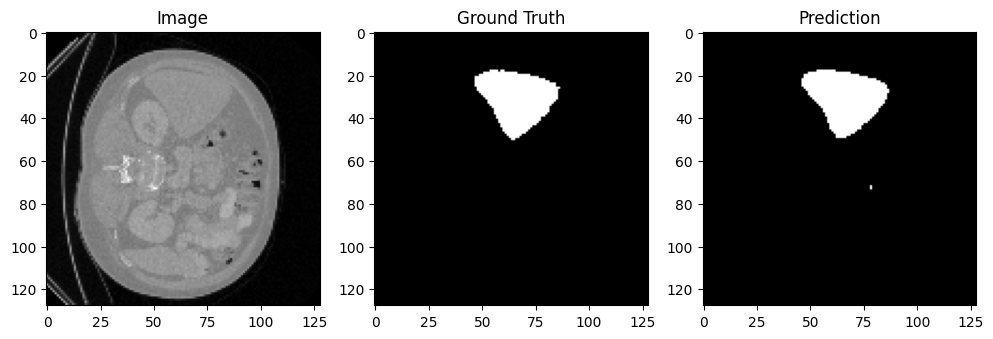

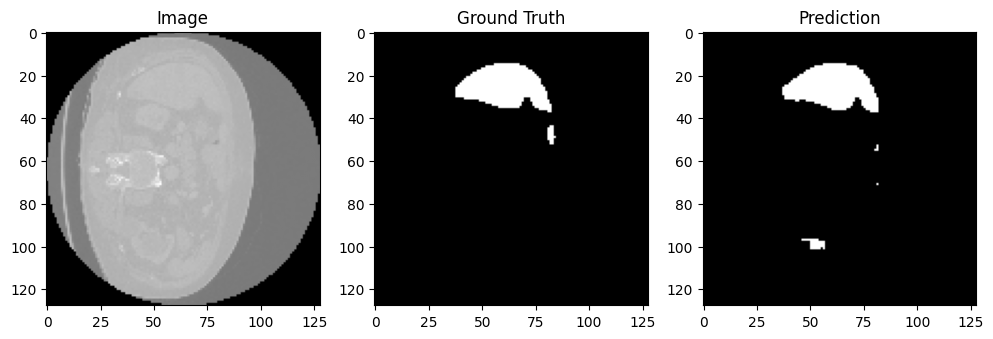

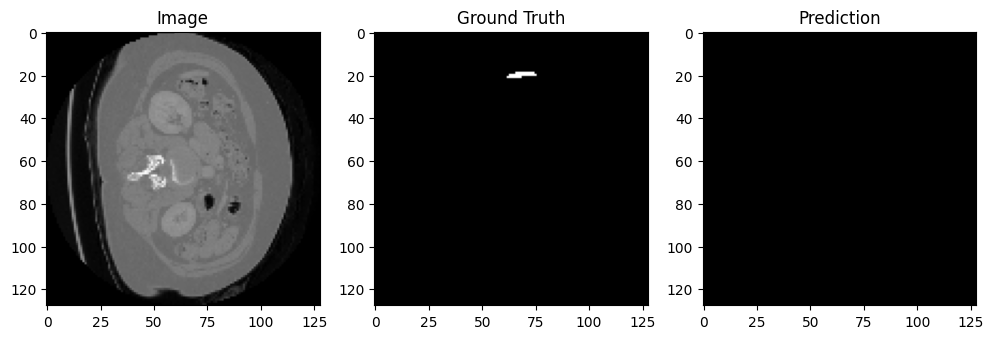

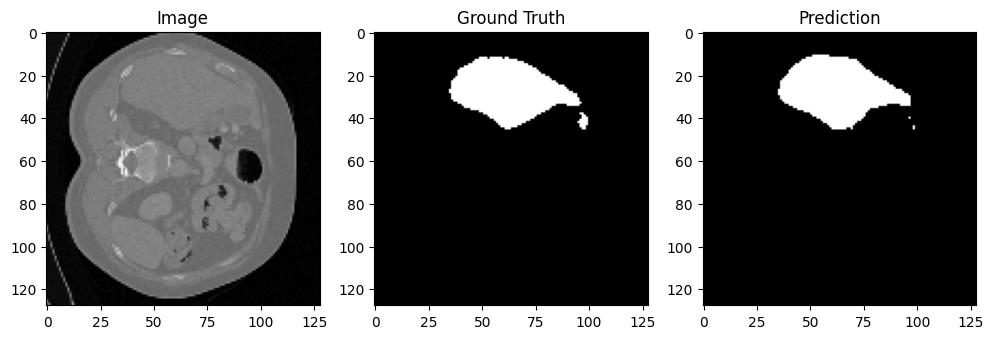

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import nibabel as nib
import os
import cv2

# ⚙️ Utility to load a NIfTI volume and resize slices
def load_nii_volume(path, target_shape=(128, 128)):
    volume = nib.load(path).get_fdata()
    volume = np.transpose(volume, (2, 0, 1))  # Slices in axis 0
    resized = [cv2.resize(slice, target_shape, interpolation=cv2.INTER_NEAREST) for slice in volume]
    return np.array(resized)

# ✅ Collect all training data (non-empty only)
def load_dataset(image_dirs, mask_dir):
    X_all, Y_all = [], []
    for folder in image_dirs:
        for fname in sorted(os.listdir(folder)):
            if fname.endswith('.nii'):
                img_path = os.path.join(folder, fname)
                seg_path = os.path.join(mask_dir, fname.replace("volume", "segmentation"))

                if not os.path.exists(seg_path):
                    continue  # Skip if matching segmentation not found

                X = load_nii_volume(img_path)
                Y = load_nii_volume(seg_path)

                # Normalize images
                X = (X - np.min(X)) / (np.max(X) - np.min(X) + 1e-5)
                Y = (Y > 0).astype(np.float32)

                # Filter out empty slices
                for x_slice, y_slice in zip(X, Y):
                    if np.any(y_slice > 0):
                        X_all.append(x_slice)
                        Y_all.append(y_slice)

    X_all = np.expand_dims(np.array(X_all), -1)  # Shape: (N, H, W, 1)
    Y_all = np.expand_dims(np.array(Y_all), -1)
    return X_all, Y_all

# ✅ Simple U-Net model
def get_unet_model(input_shape=(128, 128, 1)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    # Bottleneck
    b1 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    b1 = layers.Conv2D(64, 3, activation='relu', padding='same')(b1)

    # Decoder
    u1 = layers.UpSampling2D()(b1)
    u1 = layers.concatenate([u1, c2])
    c3 = layers.Conv2D(32, 3, activation='relu', padding='same')(u1)
    c3 = layers.Conv2D(32, 3, activation='relu', padding='same')(c3)

    u2 = layers.UpSampling2D()(c3)
    u2 = layers.concatenate([u2, c1])
    c4 = layers.Conv2D(16, 3, activation='relu', padding='same')(u2)
    c4 = layers.Conv2D(16, 3, activation='relu', padding='same')(c4)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c4)

    return models.Model(inputs, outputs)

# ✅ Plot predictions
def plot_predictions(X, Y, preds, num=5, threshold=0.5):
    for i in range(num):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Image")
        plt.imshow(X[i, :, :, 0], cmap='gray')

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth")
        plt.imshow(Y[i, :, :, 0], cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title("Prediction")
        pred_mask = (preds[i, :, :, 0] > threshold).astype(np.uint8)
        plt.imshow(pred_mask, cmap='gray')
        plt.show()

# ✅ Paths
image_dirs = [
    "/content/LiTS_dataset/volume_pt1",
    "/content/LiTS_dataset/volume_pt2",
    "/content/LiTS_dataset/volume_pt3"
]
mask_dir = "/content/LiTS_dataset/segmentations"

# ✅ Load data (filtered for non-empty masks)
X_all, Y_all = load_dataset(image_dirs, mask_dir)
print("✅ Loaded:", X_all.shape, Y_all.shape)

# ✅ Split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state=42)

# ✅ Model
model = get_unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ✅ Train (keep epochs low)
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=4, epochs=10)

# ✅ Predict
preds = model.predict(X_test)
print("Prediction min:", preds.min(), "max:", preds.max())

# ✅ Visualize
plot_predictions(X_test, Y_test, preds, num=5, threshold=0.3)
